# Modeling

This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

There's also a cell that allows us to step through hyperparamters for any particular model to examine how the model overfits as a hyparameter changes.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and out of time (oot) data sets.

Some of the ML algorithms are very fast and some are slow. Feel free to comment out any cells/models you want. At the bottom of the notebook you should select your final/best model and hyperparameters to run one time only and then make the business performance tables for that final model. Note once we've decided on the final model and hyperparameters we're allowed to make several trial runs of our final model train looking for a good performance on the testing data, as long as we don't make any changes to the model hyperparameters from our final choice.

Things to add: better calculation of FDR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [1]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import random
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
# This will let you see all the particular library vertsions you have loaded
# %pip list

In [3]:
%%time
vars = pd.read_csv('vars_final.csv')
print(vars.shape)
vars.head()

(97496, 22)
CPU times: user 79.7 ms, sys: 9.98 ms, total: 89.7 ms
Wall time: 89.2 ms


,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0,...,Cardnum_unique_count_for_card_state_3,Cardnum_unique_count_for_card_zip_3,Merchnum_desc_Zip_total_3,Cardnum_unique_count_for_Merchnum_3,Cardnum_actual/toal_1,Cardnum_unique_count_for_card_state_7,Cardnum_actual/max_0,Card_dow_unique_count_for_merch_state_1,Recnum,Fraud
0,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,1,1.0,...,1,1,3.62,1,1.0,1,1.0,1,1,0
1,1,31.42,0.033333,31.42,0.000011,0.000049,31.42,31.42,1,1.0,...,1,1,31.42,1,1.0,1,1.0,1,2,0
2,1,178.49,0.033333,178.49,0.000011,0.000049,178.49,178.49,1,1.0,...,1,1,178.49,1,1.0,1,1.0,1,3,0
3,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,1,1.0,...,1,1,3.62,1,1.0,1,1.0,1,4,0
4,1,7.24,0.033333,3.62,0.016667,0.071429,7.24,7.24,1,0.5,...,1,1,7.24,1,0.5,1,1.0,1,5,0


In [4]:
# set the number of variables desired here, and set the names of the y and record label properly
NVARS = 10

# vars.rename(columns={'record':'Recnum'},inplace=True)
# vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
detect_rate = .03
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'Cardnum_unique_count_for_card_state_1',
 'Card_Merchdesc_State_total_7',
 'Cardnum_count_1_by_30',
 'Cardnum_max_14',
 'Card_dow_vdratio_0by60',
 'Card_dow_vdratio_0by14',
 'Merchnum_desc_State_total_3',
 'Card_Merchdesc_total_7',
 'Card_dow_unique_count_for_merch_zip_7',
 'Cardnum_actual/toal_0']

In [5]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0
0,1,0,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,1,1.0
1,2,0,1,31.42,0.033333,31.42,0.000011,0.000049,31.42,31.42,1,1.0
2,3,0,1,178.49,0.033333,178.49,0.000011,0.000049,178.49,178.49,1,1.0
3,4,0,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,1,1.0
4,5,0,1,7.24,0.033333,3.62,0.016667,0.071429,7.24,7.24,1,0.5


In [6]:
vars.shape

(97496, 12)

In [7]:
vars['Fraud'].sum()

2047

In [8]:
print("fraud rate in data is",vars['Fraud'].sum()/len(vars))

fraud rate in data is 0.020995733158283417


In [9]:
vars.head(10)

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0
0,1,0,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,1,1.000000
1,2,0,1,31.42,0.033333,31.42,0.000011,0.000049,31.42,31.42,1,1.000000
2,3,0,1,178.49,0.033333,178.49,0.000011,0.000049,178.49,178.49,1,1.000000
3,4,0,1,3.62,0.033333,3.62,0.000011,0.000049,3.62,3.62,1,1.000000
4,5,0,1,7.24,0.033333,3.62,0.016667,0.071429,7.24,7.24,1,0.500000
5,6,0,1,3.67,0.033333,3.67,0.000011,0.000049,3.67,3.67,1,1.000000
6,7,0,1,3.62,0.033333,3.62,0.000011,0.000049,7.24,3.62,1,1.000000
7,8,0,1,230.32,0.033333,230.32,0.000011,0.000049,230.32,230.32,1,1.000000
8,9,0,1,62.11,0.033333,62.11,0.000011,0.000049,62.11,62.11,1,1.000000
9,10,0,1,10.86,0.033333,3.62,0.016667,0.071429,10.86,10.86,1,0.333333


In [10]:
vars.shape

(97496, 12)

In [11]:
vars.describe()

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0
count,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000
mean,48915.137247,0.020996,1.724266,676.571639,0.008823,1194.385741,0.003231,0.020482,1413.472998,676.717953,1.892016,0.765940
std,28262.212670,0.143371,1.568565,4074.921736,0.008372,1856.894526,0.004996,0.026914,5123.221915,4074.945381,1.874101,0.355093
min,1.000000,0.000000,1.000000,0.010000,0.000078,0.140000,0.000007,0.000039,0.010000,0.010000,1.000000,0.000014
25%,24428.750000,0.000000,1.000000,52.500000,0.003226,307.000000,0.000152,0.001587,99.900000,52.500000,1.000000,0.500000
50%,48916.000000,0.000000,1.000000,189.000000,0.005556,801.660000,0.000370,0.002976,356.450000,189.000000,1.000000,1.000000
75%,73402.250000,0.000000,2.000000,590.000000,0.011111,1743.000000,0.004762,0.042857,1325.600000,590.000000,2.000000,1.000000
max,97852.000000,1.000000,21.000000,306633.410000,0.033333,47900.000000,0.016667,0.071429,307302.580000,306633.410000,38.000000,1.000000


In [12]:
# find the row i vars that corresponds to 11/1 for the OOT
test = vars[vars['Recnum'] > 85264]
test.head(10)

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0
84935,85265,0,1,174.61,0.016667,225.00,0.000074,0.000317,174.61,174.61,1,1.0
84936,85266,0,1,53.00,0.002778,395.00,0.000278,0.001190,53.00,53.00,1,1.0
84937,85267,0,1,25.00,0.004762,531.25,0.000417,0.002976,25.00,25.00,2,1.0
84938,85268,0,1,97.17,0.004762,395.04,0.000194,0.001661,97.17,97.17,1,1.0
84939,85269,0,1,6.51,0.016667,6.51,0.000167,0.001429,6.51,6.51,1,1.0
84940,85270,0,1,170.00,0.016667,170.00,0.000260,0.001116,170.00,170.00,1,1.0
84941,85271,0,1,250.00,0.002564,250.00,0.000149,0.001786,250.00,250.00,2,1.0
84942,85272,0,1,15.00,0.016667,103.60,0.000167,0.001429,15.00,15.00,1,1.0
84943,85273,0,1,300.00,0.006667,2105.00,0.000024,0.001984,300.00,300.00,1,1.0
84944,85274,0,1,133.20,0.002564,268.20,0.001042,0.004464,133.20,133.20,2,1.0


In [13]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0
1,0
2,0
3,0
4,0


## Scale and truncate field values

In [14]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0
count,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000,97496.000000
mean,1.724266,676.571639,0.008823,1194.385741,0.003231,0.020482,1413.472998,676.717953,1.892016,0.765940
std,1.568565,4074.921736,0.008372,1856.894526,0.004996,0.026914,5123.221915,4074.945381,1.874101,0.355093
min,1.000000,0.010000,0.000078,0.140000,0.000007,0.000039,0.010000,0.010000,1.000000,0.000014
25%,1.000000,52.500000,0.003226,307.000000,0.000152,0.001587,99.900000,52.500000,1.000000,0.500000
50%,1.000000,189.000000,0.005556,801.660000,0.000370,0.002976,356.450000,189.000000,1.000000,1.000000
75%,2.000000,590.000000,0.011111,1743.000000,0.004762,0.042857,1325.600000,590.000000,2.000000,1.000000
max,21.000000,306633.410000,0.033333,47900.000000,0.016667,0.071429,307302.580000,306633.410000,38.000000,1.000000


In [15]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [16]:
# Outlier treatment: use this to limit variables. For some problems it helps
Clip = 10

In [17]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
X = (X - X.mean()) / X.std()
X.describe()

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0
count,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04,9.749600e+04
mean,1.049460e-17,-7.287917e-18,-5.830333e-19,7.870950e-18,-1.472159e-17,1.224370e-17,-1.166067e-18,-1.049460e-17,3.119228e-17,-4.372750e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.651796e-01,-3.346282e-01,-1.044444e+00,-7.194261e-01,-6.452996e-01,-7.595529e-01,-4.318529e-01,-3.346955e-01,-5.031954e-01,-2.156969e+00
25%,-4.651796e-01,-3.065413e-01,-6.685133e-01,-5.318162e-01,-6.163864e-01,-7.020303e-01,-3.999404e-01,-3.066096e-01,-5.031954e-01,-7.489285e-01
50%,-4.651796e-01,-2.335016e-01,-3.902418e-01,-2.293881e-01,-5.725765e-01,-6.504263e-01,-3.179788e-01,-2.335723e-01,-5.031954e-01,6.591519e-01
75%,1.782986e-01,-1.893059e-02,2.733285e-01,3.461339e-01,3.065090e-01,8.313456e-01,-8.358364e-03,-1.900840e-02,6.696772e-02,6.591519e-01
max,1.009425e+01,2.183188e+01,2.927610e+00,1.136351e+01,2.689572e+00,1.892914e+00,1.638719e+01,2.183128e+01,1.069083e+01,6.591519e-01


In [18]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this OOT record number to whatever is appropriate for your data
oot_recnum = 85264
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]
Y_oot.sum()

Fraud    297
dtype: int64

## Look at PCA

In [19]:
len(X_trntst.columns)

10

In [20]:
X_trntst_save = X_trntst.copy()

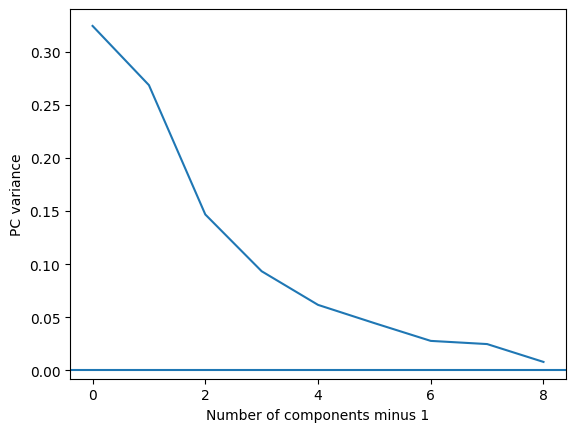

In [21]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [22]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 4, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4
0,-1.233799,-0.146768,-1.261853,2.670857
1,-1.217854,-0.125352,-1.258504,2.668163
2,-1.133501,-0.012059,-1.240786,2.653911
3,-1.233799,-0.146768,-1.261853,2.670857
4,1.747323,-2.263030,-3.108010,1.383728


In [23]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

,PC1,PC2,PC3,PC4
85264,0.474670,-0.992169,1.246312,-0.399651
85265,1.595099,-2.099471,-2.338872,1.408899
85266,-0.171959,1.949085,-0.161534,0.375554
85267,-1.073062,0.429463,0.660778,-0.213056
85268,-1.238510,0.678886,-0.019114,-0.217072


In [24]:
X_trntst.describe()

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0
count,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000,85264.000000
mean,0.004006,0.002794,-0.013411,0.003866,0.000122,0.003494,0.011369,0.002805,0.004227,-0.007076
std,1.007299,1.029148,0.996083,0.988241,0.999618,1.000623,1.038863,1.029151,1.014974,1.003383
min,-0.465180,-0.334628,-1.044444,-0.719426,-0.645300,-0.759504,-0.431853,-0.334696,-0.503195,-2.156969
25%,-0.465180,-0.307403,-0.680554,-0.528478,-0.616386,-0.699287,-0.400153,-0.307467,-0.503195,-0.748928
50%,-0.465180,-0.234920,-0.390242,-0.220376,-0.572577,-0.640374,-0.318782,-0.234966,-0.503195,0.659152
75%,0.178299,-0.019391,0.273329,0.354082,0.306509,0.831346,-0.004259,-0.019273,0.066968,0.659152
max,10.094246,21.831881,2.927610,11.363510,2.689572,1.892914,16.387194,21.831284,10.690830,0.659152


In [25]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12232.000000,12232.000000,12232.000000,12232.000000
mean,-0.084839,-0.037318,-0.060807,0.090004
std,1.689561,1.360119,1.158176,0.966594
min,-1.696425,-6.345955,-4.842932,-4.632864
25%,-1.295068,-0.697445,-0.557728,-0.438803
50%,-0.893845,0.194860,-0.029108,-0.109650
75%,1.045609,0.502024,0.389831,0.438306
max,21.527572,29.137615,9.748135,5.452739


In [26]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [27]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4
count,8.526400e+04,8.526400e+04,8.526400e+04,8.526400e+04
mean,1.000013e-17,-7.333430e-18,-9.000119e-18,2.000026e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-9.533328e-01,-4.052689e+00,-5.196134e+00,-4.686439e+00
25%,-6.921927e-01,-4.952199e-01,-4.252566e-01,-5.479011e-01
50%,-4.120381e-01,1.169866e-01,1.252057e-02,-1.881926e-01
75%,5.904588e-01,3.207532e-01,3.698016e-01,3.265700e-01
max,1.341726e+01,1.839694e+01,1.136849e+01,6.388562e+00


In [28]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12232.000000,12232.000000,12232.000000,12232.000000
mean,-0.046605,-0.022527,-0.049643,0.092140
std,0.928131,0.821052,0.945546,0.989529
min,-0.931901,-3.830809,-3.953814,-4.742789
25%,-0.711423,-0.421021,-0.455334,-0.449215
50%,-0.491018,0.117629,-0.023764,-0.112251
75%,0.574387,0.303053,0.318262,0.448706
max,11.825793,17.589258,7.958466,5.582118


In [29]:
X_trntst_pca.shape

(85264, 4)

In [30]:
X_oot_orig_pca.shape

(12232, 4)

## Subsample the larger class if desired

In [31]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.020524488647025708
(3464, 10) 3464


In [32]:
# We do a manual cross validation by running each model nitermax times for each choice of hyperparameters. The good
# statistical measurement of the model performance is the average across all these nitermax runs.
niter = 0
nitermax = 10
jittersize = .1
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and/or just explore one model type. You can also just rerun any single cell multiple times (hit shift-enter on that cell) as you "manually" explore different model hyperparameters.

In [33]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

In [34]:
%%time
# Logistic regression

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = LogisticRegression()
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['log reg',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.6790322580645162 0.6823529411764706 0.46464646464646464
1 0.6847133757961783 0.6578947368421053 0.4612794612794613
2 0.6936135812449474 0.6413255360623782 0.468013468013468
3 0.6883645240032547 0.6737044145873321 0.468013468013468
4 0.6849427168576104 0.6685606060606061 0.4713804713804714
5 0.6948160535117057 0.6516245487364621 0.47474747474747475
6 0.6733708769107 0.6982248520710059 0.468013468013468
7 0.6828266228430567 0.6810506566604128 0.4612794612794613
8 0.677786818551668 0.690978886756238 0.46464646464646464
9 0.6894308943089431 0.6653846153846154 0.4612794612794613
trn    0.68489
tst    0.67111
oot    0.46633
dtype: float64
CPU times: user 10.7 s, sys: 1.07 s, total: 11.7 s
Wall time: 1.57 s


In [35]:
%%time
# Single DT

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier()
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['DT',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1

print(FDR.mean())
model_counter = model_counter + 1

0 1.0 0.6489151873767258 0.39730639730639733
1 1.0 0.6279926335174953 0.35353535353535354
2 1.0 0.667910447761194 0.3939393939393939
3 1.0 0.6270833333333333 0.3872053872053872
4 1.0 0.6449912126537786 0.39057239057239057
5 1.0 0.6535433070866141 0.40404040404040403
6 1.0 0.6199575371549894 0.4276094276094276
7 1.0 0.6377358490566037 0.43097643097643096
8 1.0 0.6554307116104869 0.3367003367003367
9 1.0 0.660482374768089 0.4175084175084175
trn    1.000000
tst    0.644404
oot    0.393939
dtype: float64
CPU times: user 5.39 s, sys: 1.43 s, total: 6.82 s
Wall time: 5.21 s


In [36]:
%%time
# RF

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = RandomForestClassifier()
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['RF',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 1.0 0.8269581056466302 0.5521885521885522
1 1.0 0.8122676579925651 0.5117845117845118
2 1.0 0.7707129094412332 0.531986531986532
3 1.0 0.8038461538461539 0.5454545454545454
4 1.0 0.8015564202334631 0.5454545454545454
5 1.0 0.8014571948998178 0.5454545454545454
6 1.0 0.7980952380952381 0.5656565656565656
7 1.0 0.7922077922077922 0.5757575757575758
8 1.0 0.8091743119266055 0.569023569023569
9 1.0 0.8326848249027238 0.5488215488215489
trn    1.000000
tst    0.804896
oot    0.549158
dtype: float64
CPU times: user 1min 32s, sys: 543 ms, total: 1min 32s
Wall time: 1min 33s


In [37]:
%%time
# LGBM

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier()

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.9876948318293683 0.8229755178907722 0.468013468013468
1 0.9806138933764136 0.8046875 0.5555555555555556
2 0.9774193548387097 0.8333333333333334 0.49158249158249157
3 0.9892561983471074 0.8314814814814815 0.5185185185185185
4 0.9856230031948882 0.821285140562249 0.5252525252525253
5 0.9752883031301482 0.8339552238805971 0.5252525252525253
6 0.9854132901134521 0.8081395348837209 0.5420875420875421
7 0.9804719283970708 0.8023032629558541 0.5252525252525253
8 0.9861111111111112 0.8155893536121673 0.5622895622895623
9 0.9886547811993517 0.7868217054263565 0.4983164983164983
trn    0.983655
tst    0.816057
oot    0.521212
dtype: float64
CPU times: user 9.93 s, sys: 4.6 s, total: 14.5 s
Wall time: 4.56 s


In [38]:
%%time
# LGBM with SMOTE
from imblearn.over_sampling import SMOTE

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
    sm = SMOTE()
    
    X_trn_sm, Y_trn_sm = sm.fit_resample(X_trn,Y_trn)
    
    print(niter, X_trn.shape,Y_trn.shape)
    print(niter, X_trn_sm.shape,Y_trn_sm.shape)
    print(Y_trn.sum())
    print(Y_trn_sm.sum())

    model = lgb.LGBMClassifier()

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn_sm, Y_trn_sm.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM with SMOTE',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 (59684, 10) (59684, 1)
0 (116956, 10) (116956, 1)
Fraud    1206
dtype: int64
Fraud    58478
dtype: int64
0 0.8598673300165838 0.78125 0.4781144781144781
1 (59684, 10) (59684, 1)
1 (116962, 10) (116962, 1)
Fraud    1203
dtype: int64
Fraud    58481
dtype: int64
1 0.8661679135494597 0.7550274223034735 0.48484848484848486
2 (59684, 10) (59684, 1)
2 (117018, 10) (117018, 1)
Fraud    1175
dtype: int64
Fraud    58509
dtype: int64
2 0.8561702127659574 0.7721739130434783 0.4713804713804714
3 (59684, 10) (59684, 1)
3 (116904, 10) (116904, 1)
Fraud    1232
dtype: int64
Fraud    58452
dtype: int64
3 0.8652597402597403 0.7760617760617761 0.5185185185185185
4 (59684, 10) (59684, 1)
4 (116952, 10) (116952, 1)
Fraud    1208
dtype: int64
Fraud    58476
dtype: int64
4 0.8567880794701986 0.8007380073800738 0.5218855218855218
5 (59684, 10) (59684, 1)
5 (116892, 10) (116892, 1)
Fraud    1238
dtype: int64
Fraud    58446
dtype: int64
5 0.8449111470113085 0.794921875 0.46464646464646464
6 (59684, 10) (59684

In [39]:
# %%time
# # LGBM with jitter

# jittersize = .1
# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
#     print(niter, X_trn.shape,Y_trn.shape)
    
#     X_trn_bads = X_trn[Y_trn == 1]
#     Y_trn_bads = Y_trn[Y_trn == 1]
    
#     print(X_trn_bads.head())
#     for i in range(2):
#         X_trn_more = X_trn_bads*(1+jittersize*random.uniform(-1,1))
#         X_trn = X_trn.append(X_trn_more,ignore_index=True)
#         Y_trn = Y_trn.append(Y_trn_bads,ignore_index=True)
        
#     print(niter, X_trn.shape,Y_trn.shape)

#     model = lgb.LGBMClassifier()

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['LGBM with jitter',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [40]:
%%time
# NN

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
      
    model = MLPClassifier(hidden_layer_sizes=(2,2))

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.03183673469387755 0.02666666666666667 0.06397306397306397
1 0.6919354838709677 0.6843137254901961 0.48484848484848486
2 0.7103960396039604 0.6951672862453532 0.5117845117845118
3 0.6947115384615384 0.6653386454183267 0.4882154882154882
4 0.7058823529411765 0.6869244935543278 0.5050505050505051
5 0.6842961757526445 0.6928982725527831 0.48148148148148145
6 0.6983372921615202 0.6714579055441479 0.4882154882154882
7 0.7049873203719358 0.654320987654321 0.48148148148148145
8 0.6987654320987654 0.7140186915887851 0.494949494949495
9 0.030327214684756583 0.030181086519114688 0.06397306397306397
trn    0.565148
tst    0.552129
oot    0.406397
dtype: float64
CPU times: user 20.7 s, sys: 8.69 s, total: 29.4 s
Wall time: 12.3 s


In [41]:
# %%time
# # NN on pc's

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = MLPClassifier())

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['NN_PCs',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [42]:
# %%time
# # GBC

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = GradientBoostingClassifier()

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['GBC',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [43]:
%%time
# Catboost

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = CatBoostClassifier(verbose=0)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.9354026845637584 0.8315412186379928 0.569023569023569
1 0.9340478153338829 0.8100558659217877 0.5454545454545454
2 0.9451073985680191 0.8113590263691683 0.5555555555555556
3 0.9330645161290323 0.8470588235294118 0.494949494949495
4 0.9417152373022482 0.8087431693989071 0.5589225589225589
5 0.9440842787682334 0.812015503875969 0.5488215488215489
6 0.9367194004995837 0.8142076502732241 0.5286195286195287
7 0.9361179361179361 0.8147448015122873 0.5420875420875421
8 0.9429502852485737 0.8164435946462715 0.5117845117845118
9 0.930921052631579 0.8539325842696629 0.5622895622895623
trn    0.938013
tst    0.822010
oot    0.541751
dtype: float64
CPU times: user 2min 29s, sys: 47.1 s, total: 3min 16s
Wall time: 48.6 s


In [44]:
%%time
# NOTE this cell has been substantially modified to evaluate a sampled trn/tst data set. 
# Only use this cell if you do downsampling of the goods.
# each good needs to have a weight of (1-actual_ratio)/sample_ratio_desired
# it's hard to get the correct FDR@3% for the actual train and test, so I just use the original trntst after the model is built for evaluation

xmult = actual_good_fraction / (actual_bad_fraction * sample_ratio_desired)
print(xmult)
FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_sampled, Y_trntst_sampled, test_size = .3)

    model = lgb.LGBMClassifier()

    model.fit(X_trn, Y_trn.values.ravel())  
    
    X_oot = X_oot_orig.copy()
    X_trn = X_trntst.copy()
    Y_trn = Y_trntst.copy()
    X_tst = X_trntst.copy()
    Y_tst = Y_trntst.copy()

    predictions = model.predict_proba(X_trntst)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trntst['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_trntst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_trntst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM sampled',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

47.72228571428572
0 0.7868571428571428 0.7868571428571428 0.49158249158249157
1 0.788 0.788 0.5117845117845118
2 0.7691428571428571 0.7691428571428571 0.5218855218855218
3 0.7885714285714286 0.7885714285714286 0.5084175084175084
4 0.7702857142857142 0.7702857142857142 0.5050505050505051
5 0.7828571428571428 0.7828571428571428 0.5185185185185185
6 0.7931428571428571 0.7931428571428571 0.5387205387205387
7 0.7828571428571428 0.7828571428571428 0.5050505050505051
8 0.7954285714285714 0.7954285714285714 0.5016835016835017
9 0.8005714285714286 0.8005714285714286 0.5084175084175084
trn    0.785771
tst    0.785771
oot    0.511111
dtype: float64
CPU times: user 22.3 s, sys: 3.92 s, total: 26.2 s
Wall time: 5.57 s


In [45]:
# %%time
# # Catboost on pc's

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = CatBoostClassifier()

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['cat boost_PCs',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [46]:
# %%time
# # unsupervised model using pc's. 

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     pow = 2
#     oop = 1/pow
#     predictions = ((X_trn.abs()**pow).sum(axis=1))**oop
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = ((X_tst.abs()**pow).sum(axis=1))**oop
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = ((X_oot.abs()**pow).sum(axis=1))**oop
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['unsupervised outliers',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

In [47]:
%%time
# XGB

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = xgb.XGBClassifier(booster='gbtree')

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['XGB',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.9884201819685691 0.833641404805915 0.4781144781144781
1 0.9835796387520526 0.8477443609022557 0.4882154882154882
2 0.9879711307137129 0.8548707753479126 0.5151515151515151
3 0.9877551020408163 0.8361904761904762 0.5084175084175084
4 0.9845653939886271 0.8670520231213873 0.48484848484848486
5 0.9835796387520526 0.8703007518796992 0.46464646464646464
6 0.9819672131147541 0.8339622641509434 0.46464646464646464
7 0.9838056680161943 0.8504854368932039 0.5252525252525253
8 0.982011447260834 0.8425047438330171 0.4882154882154882
9 0.9794238683127572 0.8373831775700935 0.49158249158249157
trn    0.984308
tst    0.847414
oot    0.490909
dtype: float64
CPU times: user 1min 33s, sys: 18 s, total: 1min 51s
Wall time: 15 s


In [48]:
%%time
# Knn
# Knn can be very slow with a lot of records.

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    model = KNeighborsClassifier() 
    
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['Knn',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR.mean())
model_counter = model_counter + 1

0 0.859805510534846 0.7441860465116279 0.4511784511784512
1 0.8673894912427023 0.7422867513611615 0.46464646464646464
2 0.8609539207760711 0.7426900584795322 0.4781144781144781
3 0.8748936170212765 0.7269565217391304 0.48484848484848486
4 0.8573743922204214 0.748062015503876 0.468013468013468
5 0.8648208469055375 0.7375478927203065 0.4612794612794613
6 0.8770764119601329 0.7326007326007326 0.4612794612794613
7 0.8635990139687757 0.7392120075046904 0.47474747474747475
8 0.8642681929681112 0.7210626185958254 0.48484848484848486
9 0.8672496025437202 0.725609756097561 0.4882154882154882
trn    0.865743
tst    0.736021
oot    0.471717
dtype: float64
CPU times: user 27.8 s, sys: 437 ms, total: 28.2 s
Wall time: 26.9 s


In [49]:
# %%time
# # SVM
# # SVM can be very slow. It scales like the # training records cubed

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = svm.SVC(kernel='poly',probability=True)
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['SVM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR.mean())
# model_counter = model_counter + 1

## Model comparison plots

In [50]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,OOT
0,log reg,0.679032,0.682353,0.464646
1,log reg,0.684713,0.657895,0.461279
2,log reg,0.693614,0.641326,0.468013
3,log reg,0.688365,0.673704,0.468013
4,log reg,0.684943,0.668561,0.47138
5,log reg,0.694816,0.651625,0.474747
6,log reg,0.673371,0.698225,0.468013
7,log reg,0.682827,0.681051,0.461279
8,log reg,0.677787,0.690979,0.464646
9,log reg,0.689431,0.665385,0.461279


In [51]:
df.shape

(100, 4)

In [52]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], var_name=['Type'], value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,log reg,Trn,0.679032
1,log reg,Trn,0.684713
2,log reg,Trn,0.693614
3,log reg,Trn,0.688365
4,log reg,Trn,0.684943


In [53]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,log reg,Trn,0.679032
1,log reg,Trn,0.684713
2,log reg,Trn,0.693614
3,log reg,Trn,0.688365
4,log reg,Trn,0.684943


In [54]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT          
                     mean       std      mean       std      mean       std
Model                                                                      
DT                    1.0  0.000000  0.644404  0.015805  0.393939  0.030074
Knn              0.865743  0.006263  0.736021  0.009030  0.471717  0.012341
LGBM             0.983655  0.004876  0.816057  0.015520  0.521212  0.029042
LGBM sampled     0.785771  0.010077  0.785771  0.010077  0.511111  0.012875
LGBM with SMOTE  0.857216  0.006137  0.772675  0.015831  0.480135  0.023067
NN               0.565148  0.281576  0.552129  0.276519  0.406397  0.180742
RF                    1.0  0.000000  0.804896  0.017421  0.549158  0.018608
XGB              0.984308  0.002948  0.847414  0.013316  0.490909  0.020190
cat boost        0.938013  0.005032   0.82201  0.016378  0.541751  0.023513
log reg           0.68489  0.006905   0.67111  0.017772   0.46633  0.004559

In [55]:
df.head()

,Model,Trn,Tst,OOT
0,log reg,0.679032,0.682353,0.464646
1,log reg,0.684713,0.657895,0.461279
2,log reg,0.693614,0.641326,0.468013
3,log reg,0.688365,0.673704,0.468013
4,log reg,0.684943,0.668561,0.47138


In [56]:
best_OOT = df['OOT'].max()
best_OOT

0.5757575757575758

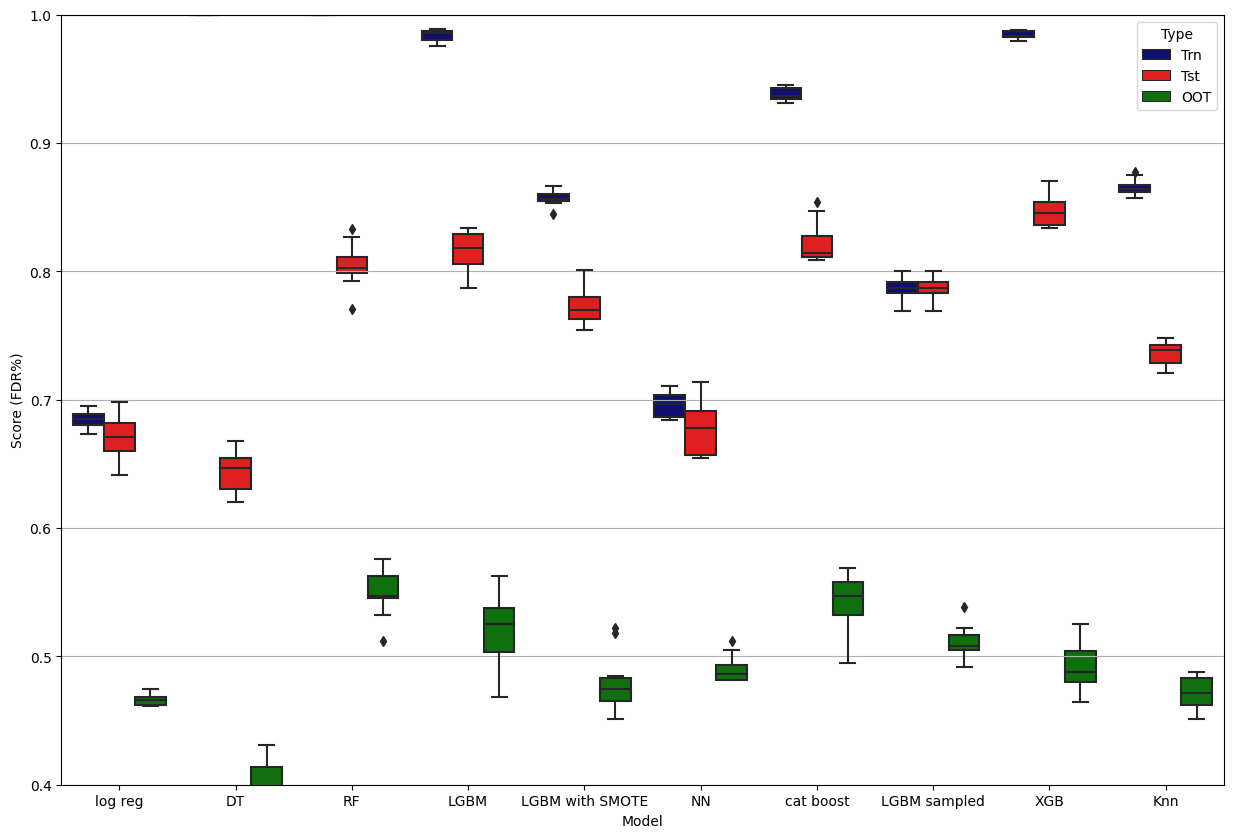

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(.4,1.)
plt.ylabel('Score (FDR%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

In [58]:
print('duration: ', datetime.now() - start_time)

duration:  0:03:41.918033


This next cell can be used to explore overfitting

0 0.7743254292722813 0.7039848197343453 0.5656565656565656
1 0.755718954248366 0.7262357414448669 0.4713804713804714
2 0.7658697444352844 0.7541899441340782 0.48148148148148145
loop trn tst oot 120 0.25510156977288134 0.24271227836814338 0.16872427983539093
0 0.7696078431372549 0.7262357414448669 0.47474747474747475
1 0.7646579804560261 0.7260536398467433 0.5757575757575758
2 0.777307366638442 0.7539543057996485 0.5521885521885522
loop trn tst oot 110 0.25684146558130255 0.2451381874545843 0.17807706696595588
0 0.7726161369193154 0.7017208413001912 0.494949494949495
1 0.7706645056726094 0.7267441860465116 0.5589225589225589
2 0.7886977886977887 0.720226843100189 0.49158249158249157
loop trn tst oot 100 0.259108714587746 0.23874354116076577 0.1717171717171717
0 0.7931596091205212 0.7375478927203065 0.5656565656565656
1 0.8003300330033003 0.7193308550185874 0.4781144781144781
2 0.7786688051323175 0.7614314115308151 0.48148148148148145
loop trn tst oot 90 0.26357316080623766 0.24647890658

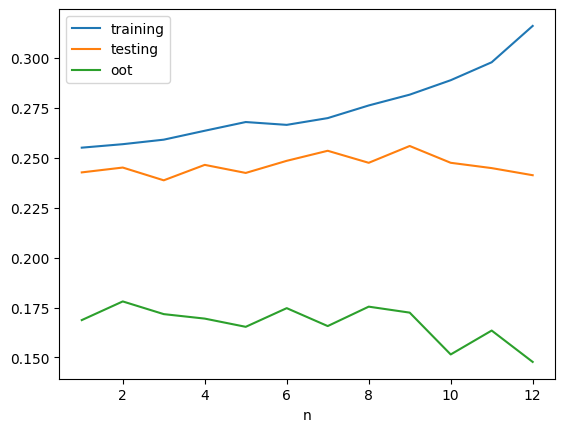

CPU times: user 17.8 s, sys: 118 ms, total: 17.9 s
Wall time: 17.6 s


In [59]:
%%time
# This cell is used only to examine overfitting for ant particular model type.
# One can iterate through a hyperparameter's value, either increasing or decreasing it, and watching the overfitting.
nitermax2 = 3 # Lower the number of model builds for each value of hyperparameters so this cell runs faster.
training = []
testing = []
oot = []
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])

# Here's where we set the manner of the hyperparameter's ranga and increment.
for i in range(120,4,-10):

# Now just run the model as before.
    for niter in range(nitermax2):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
  
        io2 = int(i/2) # the min_samples_leaf can be set to half the min_samples_split for simplicity.
        model = DecisionTreeClassifier(max_depth=100,min_samples_split=i,min_samples_leaf=io2)

        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*detect_rate))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*detect_rate))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*detect_rate))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

table=pd.DataFrame({'n': range(1,len(training)+1),'training':training,'testing':testing,'oot':oot})
table.set_index('n',inplace=True) 
table.plot()
plt.savefig('complexity_NN.pdf', format='pdf')
plt.show()

In [60]:
best_OOT

0.5757575757575758

The rest of the notebook makes the tables for your final model of choice. You need to run that final model only once (no CV). If you want you can run the below cell over and over by itself until it gives you a model you like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [61]:
%%time
# Note - need to set this next value to around the highest oot fdr for your model of choice.
# The model then runs a nombermof times with your fixed hyperparameters until it finds a good model.
desire = .55
print('desire =', desire)
for niter in range(50):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# Here's where you put your final model of choice.
# I run this loop a large number of times with an unreasonably high stopping criterion (the break condition)
# I then look at all these runs and select a value of the oot performance where I want to break out this loop
# and that will be my final model run of choice.
    model = lgb.LGBMClassifier()

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1
# choose a good break point
    if(FDR.loc[niter, 'oot'] > desire): break
    
model_counter = model_counter + 1

desire = 0.55
0 0.9776536312849162 0.8269617706237424 0.5117845117845118
1 0.9890848026868178 0.7924865831842576 0.5488215488215489
2 0.9855769230769231 0.8207171314741036 0.4882154882154882
3 0.9903225806451613 0.796078431372549 0.494949494949495
4 0.9841402337228714 0.8152173913043478 0.5185185185185185
5 0.9795417348608838 0.8125 0.468013468013468
6 0.9764227642276423 0.8153846153846154 0.5185185185185185
7 0.9868852459016394 0.7962264150943397 0.5521885521885522
CPU times: user 8.27 s, sys: 3.7 s, total: 12 s
Wall time: 3.74 s


In [62]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [63]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0,predicted,Fraud
93846,4.039168,-0.240185,0.593673,-0.122573,0.687799,1.362130,-0.375465,-0.240255,1.207294,-1.744911,0.991926,1
94031,7.900037,-0.324574,1.047494,-0.114619,1.512059,1.671754,-0.425850,-0.324642,5.198436,-2.142262,0.985080,1
91007,7.900037,-0.324087,2.305513,-0.185289,2.537923,1.892914,-0.425559,-0.324155,9.759741,-2.144938,0.981403,1
94098,6.613081,-0.324328,0.439221,-0.114619,2.022315,1.892914,-0.425703,-0.324395,1.207294,-2.104184,0.978474,0
96324,7.256559,-0.323033,1.369662,-0.188352,-0.637018,-0.753291,-0.173246,-0.323101,-0.503195,0.659152,0.978416,1
93907,5.326124,0.194774,0.744249,-0.114619,1.021428,1.513782,-0.115773,0.194689,2.347620,-1.222987,0.977126,1
96458,8.543516,-0.325933,1.691996,-0.153790,2.689572,1.892914,-0.426661,-0.326001,2.917783,-2.140261,0.975476,1
96249,8.543516,-0.270706,2.358835,-0.188352,2.689572,1.892914,-0.393688,-0.270776,5.768599,-2.053250,0.973732,1
90973,7.256559,-0.328159,2.264040,-0.185289,2.522758,1.892914,-0.427990,-0.328227,8.619415,-2.149524,0.971518,1
93989,6.613081,-0.221542,0.936899,-0.114619,1.355057,1.627522,-0.187428,-0.221613,4.058110,-1.989687,0.971512,1


In [64]:
cost_fraud = 400
cost_fp = 20
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud
    FDR_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp
    FDR_trn.loc[i, 'Overall Savings'] = FDR_trn.loc[i, 'Fraud Savings'] - FDR_trn.loc[i, 'FP Loss']
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud
    FDR_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp
    FDR_tst.loc[i, 'Overall Savings'] = FDR_tst.loc[i, 'Fraud Savings'] - FDR_tst.loc[i, 'FP Loss']
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot

    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,122.0,32.0,90.0,26.229508,73.770492,122.0,32.0,90.0,0.268119,30.303030,30.034911,0.355556
2,2.0,123.0,78.0,45.0,63.414634,36.585366,245.0,110.0,135.0,0.921659,45.454545,44.532886,0.814815
3,3.0,122.0,93.0,29.0,76.229508,23.770492,367.0,203.0,164.0,1.700880,55.218855,53.517975,1.237805
4,4.0,122.0,111.0,11.0,90.983607,9.016393,489.0,314.0,175.0,2.630917,58.922559,56.291641,1.794286
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,123.0,122.0,1.0,99.186992,0.813008,11743.0,11446.0,297.0,95.902807,100.000000,4.097193,38.538721
97,97.0,122.0,122.0,0.0,100.000000,0.000000,11865.0,11568.0,297.0,96.925010,100.000000,3.074990,38.949495
98,98.0,122.0,122.0,0.0,100.000000,0.000000,11987.0,11690.0,297.0,97.947214,100.000000,2.052786,39.360269
99,99.0,123.0,123.0,0.0,100.000000,0.000000,12110.0,11813.0,297.0,98.977796,100.000000,1.022204,39.774411


Max possible savings: 45,588,000.0


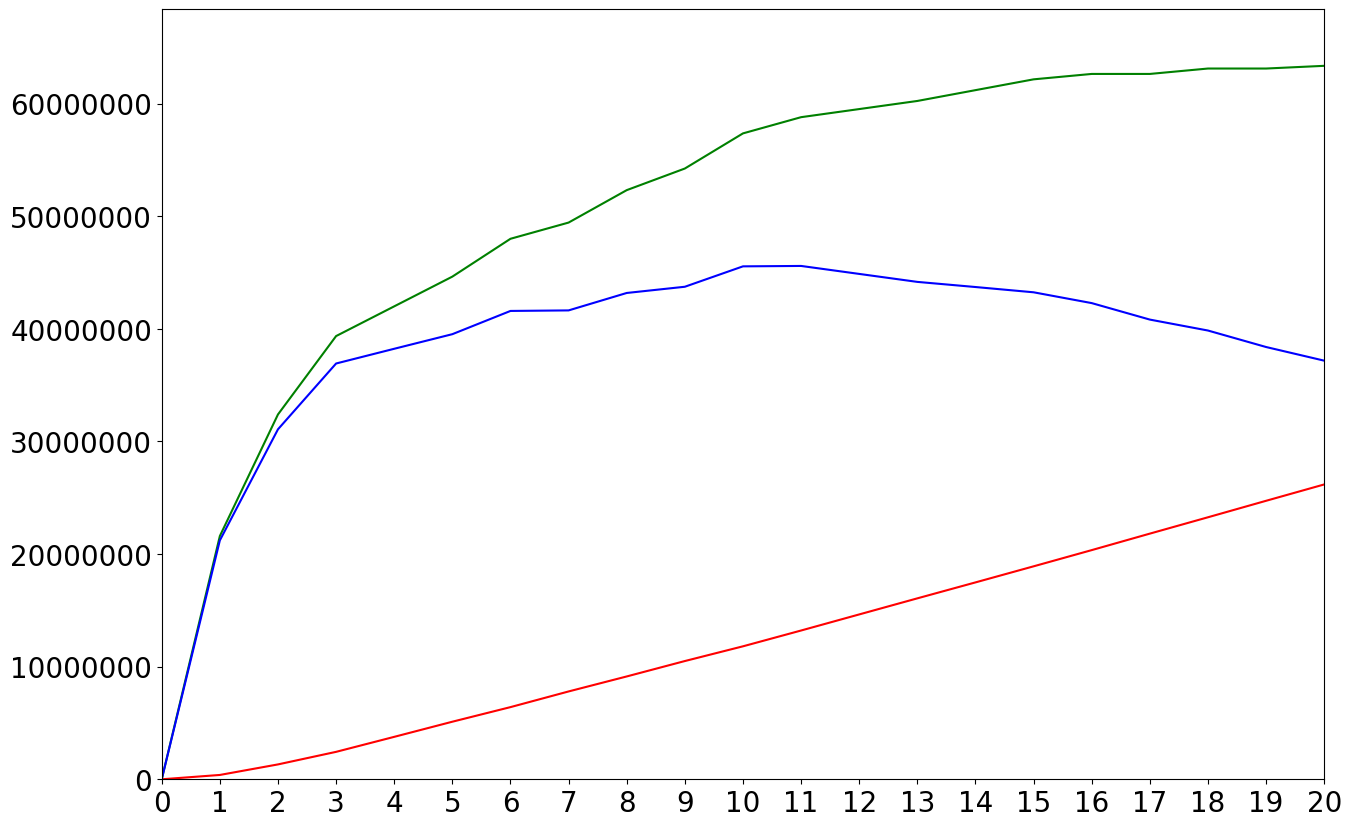

In [65]:
# xmult: oot is only 2 out of 12 months. 100,000 sample transactions out of 10 million/year
xoot = 12/2 * 10000000/100000
Financials_trn = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_tst = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
for i in range(101):
    Financials_trn.loc[i, 'Fraud Savings'] = FDR_trn.loc[i, 'cb'] * cost_fraud * xoot
    Financials_trn.loc[i, 'FP Loss'] = FDR_trn.loc[i, 'cg'] * cost_fp * xoot
    Financials_trn.loc[i, 'Overall Savings'] = Financials_trn.loc[i, 'Fraud Savings'] - Financials_trn.loc[i, 'FP Loss']
    Financials_tst.loc[i, 'Fraud Savings'] = FDR_tst.loc[i, 'cb'] * cost_fraud * xoot
    Financials_tst.loc[i, 'FP Loss'] = FDR_tst.loc[i, 'cg'] * cost_fp * xoot
    Financials_tst.loc[i, 'Overall Savings'] = Financials_tst.loc[i, 'Fraud Savings'] - Financials_tst.loc[i, 'FP Loss']
    Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud * xoot
    Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp * xoot
    Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss']

max_savings = Financials_oot['Overall Savings'].max(0)
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings * 1.5
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(15,10))
plt.plot(Financials_oot['Fraud Savings'], color='green')
plt.plot(Financials_oot['FP Loss'], color='red')
plt.plot(Financials_oot['Overall Savings'], color='blue')
xlimit = 20
interval = 1
plt.xlim(0,xlimit)
plt.ylim(0,yupper)
plt.xticks(ticks=np.linspace(0,xlimit, num=int(xlimit/interval)+1))
plt.ticklabel_format(style='plain')
plt.savefig('savings.png', format='png')

In [66]:
FDR_oot.head(10)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,122.0,32.0,90.0,26.229508,73.770492,122.0,32.0,90.0,0.268119,30.303030,30.034911,0.355556
2,2.0,123.0,78.0,45.0,63.414634,36.585366,245.0,110.0,135.0,0.921659,45.454545,44.532886,0.814815
3,3.0,122.0,93.0,29.0,76.229508,23.770492,367.0,203.0,164.0,1.700880,55.218855,53.517975,1.237805
4,4.0,122.0,111.0,11.0,90.983607,9.016393,489.0,314.0,175.0,2.630917,58.922559,56.291641,1.794286
5,5.0,123.0,112.0,11.0,91.056911,8.943089,612.0,426.0,186.0,3.569334,62.626263,59.056929,2.290323
6,6.0,122.0,108.0,14.0,88.524590,11.475410,734.0,534.0,200.0,4.474235,67.340067,62.865832,2.670000
7,7.0,122.0,116.0,6.0,95.081967,4.918033,856.0,650.0,206.0,5.446167,69.360269,63.914103,3.155340
8,8.0,123.0,111.0,12.0,90.243902,9.756098,979.0,761.0,218.0,6.376204,73.400673,67.024469,3.490826
9,9.0,122.0,114.0,8.0,93.442623,6.557377,1101.0,875.0,226.0,7.331378,76.094276,68.762898,3.871681


In [67]:
FDR.to_csv('FDR.csv')

In [68]:
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

In [69]:
Metrics = FDR_oot.copy()
num_good = Metrics['#g'].sum()
num_bad = Metrics['#b'].sum()
num_tot = Metrics['#recs'].sum()
print(num_good,num_bad,num_good+num_bad,num_tot)

11935.0 297.0 12232.0 12232.0


In [70]:
Metrics['TP'] = Metrics['cb']
Metrics['TN'] = num_good - Metrics['cg']
Metrics['FN'] = num_bad - Metrics['cb']
Metrics['FP'] = Metrics['cg']
Metrics['Accuracy'] = (Metrics['TP'] + Metrics['TN']) / num_tot
Metrics['Misclass'] = (Metrics['FP'] + Metrics['FN']) / num_tot
Metrics['FPRate'] = Metrics['FP'] / (Metrics['FP'] + Metrics['TN'])
Metrics['FPRatio'] = Metrics['FP'] / Metrics['TP']
Metrics['TPR'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FN'])
Metrics['TNR'] = Metrics['TN'] / (Metrics['TN'] + Metrics['FP'])
Metrics['Precision'] = Metrics['TP'] / (Metrics['TP'] + Metrics['FP'])
Metrics['f1'] = 2 * Metrics['Precision'] * Metrics['TPR'] / (Metrics['Precision'] + Metrics['TPR'])
Metrics.to_csv('Metrics.csv')

Text(0, 0.5, 'FDR')

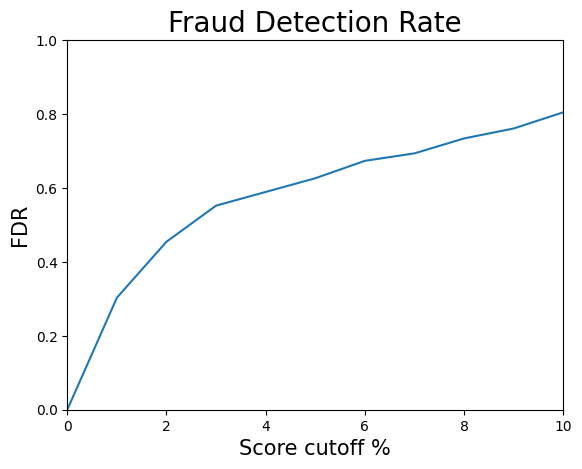

In [71]:
plt.rcParams.update({'font.size':10})
plt.plot(Metrics['bin'], Metrics['TPR'])
plt.title('Fraud Detection Rate', fontsize=20)
plt.xlim(0,10)
plt.ylim(0,1)
plt.xlabel('Score cutoff %', fontsize=15)
plt.ylabel('FDR', fontsize=15)

For a highly imbalanced problem the # goods in each bin is close to constant except for the first few bins, so the FDR curve (xaxis is bin #) and the ROC (x axis is FP, which is # goods below the cutoff) look very similar. They're only different in the first few bins where the # goods are not ~constant.

(0.0, 1.0)

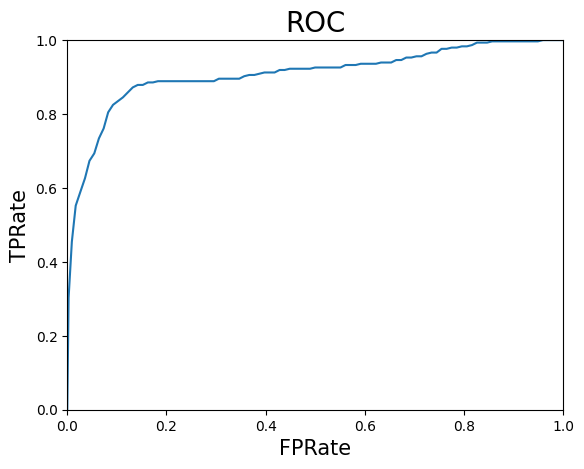

In [72]:
plt.plot(Metrics['FPRate'], Metrics['TPR'])
plt.title('ROC', fontsize=20)
plt.xlabel('FPRate',fontsize=15)
plt.ylabel('TPRate', fontsize=15)
plt.xlim(0,1)
plt.ylim(0,1)

In [73]:
print("duration: ", datetime.now() - start_time)

duration:  0:04:04.063515


In [74]:
%pwd

'/Users/stevecoggeshall/Documents/Teaching/Data sets/done/transactions/give to USC 2024'

In [75]:
%%time
df = pd.read_csv('card transactions.csv')
df.dropna(how='all', axis=1, inplace=True)
df = df[df['Transtype'] == 'P']
df = df[df['Amount'] <= 3000000]
df['Date'] = pd.to_datetime(df['Date'])
df.shape

CPU times: user 259 ms, sys: 13.4 ms, total: 273 ms
Wall time: 98.2 ms


<timed exec>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


(97496, 10)

In [76]:
df['prediction'] = model.predict_proba(X)[:,1]

In [77]:
pred_scale = 1/df['prediction'].max()
df['prediction'] = df['prediction']*pred_scale

In [78]:
df.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,0.000453
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,0.001409
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,0.003714
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,0.000453
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,0.000587


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97496 entries, 0 to 97851
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             97496 non-null  int64         
 1   Cardnum            97496 non-null  int64         
 2   Date               97496 non-null  datetime64[ns]
 3   Merchnum           94276 non-null  object        
 4   Merch description  97496 non-null  object        
 5   Merch state        96468 non-null  object        
 6   Merch zip          93149 non-null  float64       
 7   Transtype          97496 non-null  object        
 8   Amount             97496 non-null  float64       
 9   Fraud              97496 non-null  int64         
 10  prediction         97496 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 8.9+ MB


In [80]:
df_sorted = df.sort_values(by=['prediction'],ascending=False)
df_sorted.head(20)

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
77122,77123,5142225942,2010-09-21,9900020006406,GSA-FSS-ADV,VA,NaN,P,18.10,1,1.000000
63530,63531,5142249750,2010-08-13,92891948003,ONLINE SERVICES INC,TX,75230.0,P,726.74,1,0.997661
63535,63536,5142249750,2010-08-13,92891948003,ONLINE SERVICES INC,TX,75230.0,P,717.17,1,0.997661
63552,63553,5142249750,2010-08-13,92891948003,ONLINE SERVICES INC,TX,75230.0,P,728.95,1,0.997661
63520,63521,5142249750,2010-08-13,92891948003,ONLINE SERVICES INC,TX,75230.0,P,809.83,1,0.997424
45388,45389,5142134797,2010-06-15,410000971343,SIGMA-ALDRICH,MO,63103.0,P,49.57,1,0.997332
68141,68142,5142223659,2010-08-26,900009096891,C.T. ENGINEERING,OH,44103.0,P,374.46,1,0.995721
20212,20213,5142214614,2010-03-20,300600391,NEAL R GROSS & CO INC,DC,20005.0,P,4478.48,1,0.995464
42222,42223,5142111125,2010-06-05,672614430336,EWONDERS.COM,NJ,7981.0,P,4753.03,1,0.994303
42236,42237,5142111125,2010-06-05,460450006HRI6,"SENTINEL, INC.",AL,35801.0,P,4739.36,1,0.994303


# Here we're going to look at specific cards or merchants to look at the dynamics of the fraud score

In [81]:
bads = df[df['Fraud']==1]
bads['Cardnum'].value_counts().head(20)

Cardnum
5142214614    60
5142271065    58
5142140316    46
5142847398    45
5142199009    45
5142219623    44
5142189341    41
5142160778    41
5142225942    41
5142212038    39
5142181728    39
5142220919    38
5142165136    37
5142202847    37
5142138135    36
5142223659    36
5142149994    35
5142226204    35
5142260253    34
5142189108    33
Name: count, dtype: int64

In [82]:
bads['Merchnum'].value_counts().head(15)

Merchnum
930090121224     151
4353000719908    116
9108234610000     48
8834000695423     46
4503738417400     45
9900020006406     43
4620009957157     41
4503082476300     39
618901687330      36
900009045549      36
253052983001      34
938909877224      32
6006333528866     30
997674930332      30
6070095870009     27
Name: count, dtype: int64

In [83]:
card = 5142140316
# card = 5142847398
# card = 5142199009
# card = 5142160778
# card = 5142189341
# card = 5142181728
# card = 5142212038
# card = 5142220919
# card = 5142214614
# card = 5142202847
# card = 5142138135
# card = 5142271065
# card = 5142152857
# card = 5142179617
# card = 5142235211
# card = 5142197711
# card = 5142182128
# card = 5142189113
# card = 5142197563 

merch = 4353000719908
# merch = 930090121224  
# merch = 48834000695423
# merch = 44503738417400
# merch = 44620009957157
# merch = 4618901687330
# merch = 4900009045549
# merch = 49108234610000
# merch = 4253052983001
# merch = 4938909877224
# merch = 44503082476300
# merch = 46006333528866
# merch = 4997674930332
# merch = 46070095870009
# merch = 49900020006406
sample = df[df['Cardnum'] == card]
# sample = df[df['Merchnum'] == str(merch)]
sample['Fraud'].sum()

46

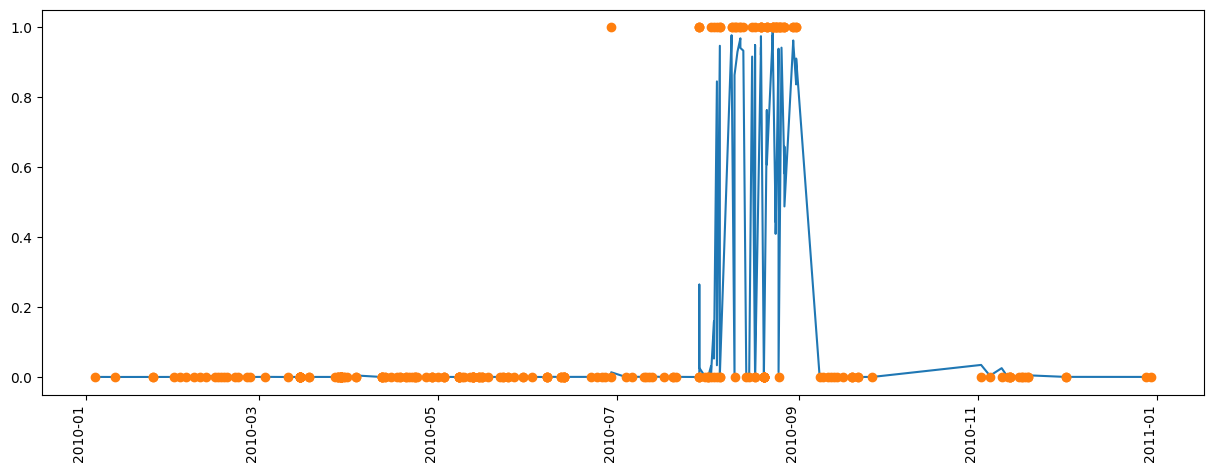

In [84]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(sample['Date'],sample['prediction'])
plt.plot_date(sample['Date'],sample['Fraud'])

In [85]:
tsample = sample[sample['Date'] > '2010-08-01']
tsample = tsample[tsample['Date'] < '2010-09-10']
tsample.reset_index(inplace=True)
tsample.reset_index(inplace=True)
tsample.rename(columns={'level_0':'counter'},inplace=True)
tsample['counter'] = tsample['counter']+1
tsample.head()

,counter,index,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,59430,59431,5142140316,2010-08-02,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,2629.20,1,0.031342
1,2,59776,59777,5142140316,2010-08-02,4620002006336,HP GSA STORE,AZ,85285.0,P,644.00,0,0.008229
2,3,59886,59887,5142140316,2010-08-03,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,560.72,1,0.158744
3,4,60227,60228,5142140316,2010-08-03,465906341338,HEWLETT PACKARD CO,CA,95747.0,P,176.00,0,0.052836
4,5,60345,60346,5142140316,2010-08-04,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,487.26,1,0.844643


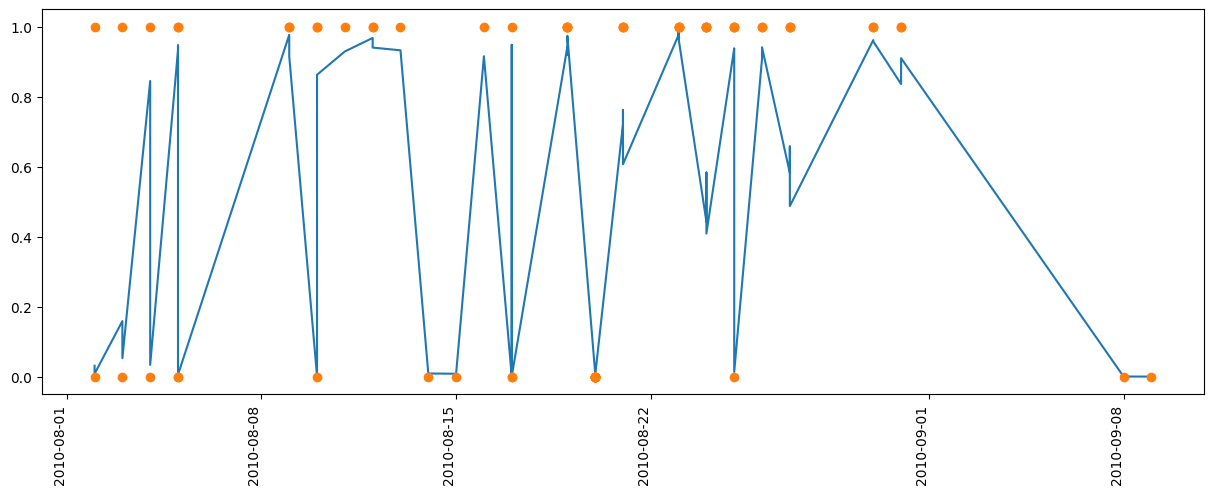

In [86]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['Date'],tsample['prediction'])
plt.plot_date(tsample['Date'],tsample['Fraud'])
plt.savefig('dynamics_time.png', format='png')

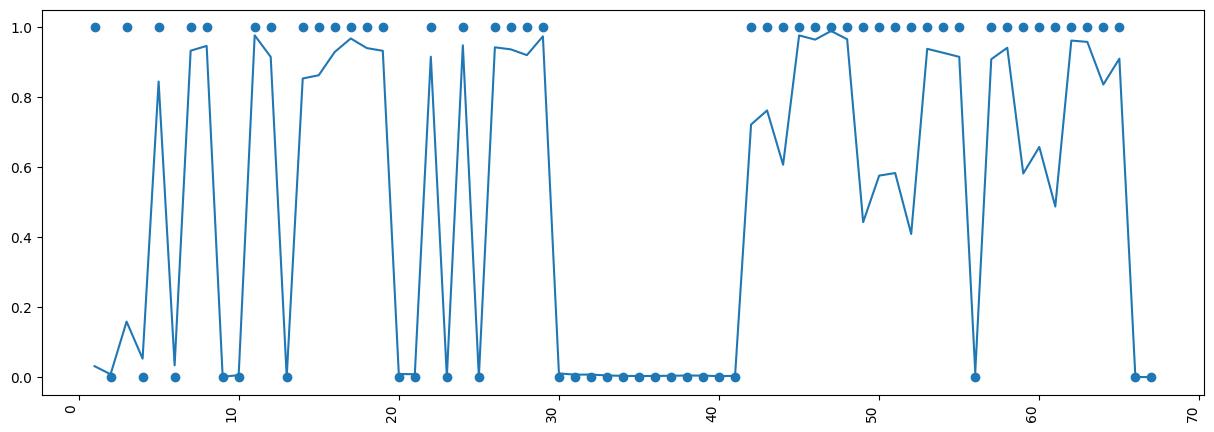

In [87]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90, ha='right')
plt.plot(tsample['counter'],tsample['prediction'])
plt.scatter(tsample['counter'],tsample['Fraud'])
plt.savefig('dynamics_count.png', format='png')

In [88]:
tsample.to_csv('dynamics_transactions.csv')
tsample.head(40)

,counter,index,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,prediction
0,1,59430,59431,5142140316,2010-08-02,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,2629.20,1,0.031342
1,2,59776,59777,5142140316,2010-08-02,4620002006336,HP GSA STORE,AZ,85285.0,P,644.00,0,0.008229
2,3,59886,59887,5142140316,2010-08-03,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,560.72,1,0.158744
3,4,60227,60228,5142140316,2010-08-03,465906341338,HEWLETT PACKARD CO,CA,95747.0,P,176.00,0,0.052836
4,5,60345,60346,5142140316,2010-08-04,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,487.26,1,0.844643
5,6,60640,60641,5142140316,2010-08-04,4620002006336,HP GSA STORE,AZ,85285.0,P,1060.00,0,0.033652
6,7,60688,60689,5142140316,2010-08-05,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,629.09,1,0.932717
7,8,60691,60692,5142140316,2010-08-05,8834000695423,STEVES COMPUTER REPAIR,CA,92656.0,P,1821.05,1,0.946421
8,9,60758,60759,5142140316,2010-08-05,930090121224,FEDEX SHP 07/24/10 AB#,TN,38118.0,P,5.16,0,0.001075
9,10,60792,60793,5142140316,2010-08-05,930090121224,FEDEX SHP 07/21/10 AB#,TN,38118.0,P,3.57,0,0.005715


In [89]:
len(tsample)

67

# Score Calibration

In [90]:
base = 600
delta = 20
odds_at_base = .1

In [91]:
df = pd.concat([X_trn_eval,X_tst_eval,X_oot_eval])
df.shape

(97496, 12)

In [92]:
df.head()

,Cardnum_unique_count_for_card_state_1,Card_Merchdesc_State_total_7,Cardnum_count_1_by_30,Cardnum_max_14,Card_dow_vdratio_0by60,Card_dow_vdratio_0by14,Merchnum_desc_State_total_3,Card_Merchdesc_total_7,Card_dow_unique_count_for_merch_zip_7,Cardnum_actual/toal_0,predicted,Fraud
66734,-0.465180,-0.318982,-0.058457,-0.701629,-0.607922,-0.699287,-0.376708,-0.319050,-0.503195,0.659152,0.000423,0
9757,1.465255,-0.311491,-0.571216,0.260424,-0.608804,-0.678071,-0.418039,-0.311559,0.066968,0.659152,0.003402,0
44324,0.178299,0.695521,-0.257528,0.457528,-0.644663,-0.759373,0.183200,0.695420,-0.503195,0.659152,0.004066,0
2875,-0.465180,-0.147352,2.927610,-0.612519,2.689572,1.892914,3.226147,-0.147426,-0.503195,-0.748928,0.002076,0
34604,-0.465180,-0.237327,-0.058457,-0.558259,-0.617451,-0.714446,-0.373759,-0.237398,-0.503195,0.659152,0.000643,0


In [93]:
calib = df.iloc[:,df.shape[1]-2:]
trn_sorted = X_trn_eval.sort_values('predicted',ascending=True)
calib = calib.sort_values('predicted')
calib.rename(columns={'predicted':'score_raw'}, inplace=True)
calib['score_raw'].clip(upper=.999, inplace=True)
calib['score_raw'].clip(lower=.00001, inplace=True)
calib.head()

,score_raw,Fraud
48200,0.000030,0
5423,0.000031,0
46674,0.000032,0
73229,0.000033,0
61983,0.000033,0


In [94]:
calib.shape

(97496, 2)

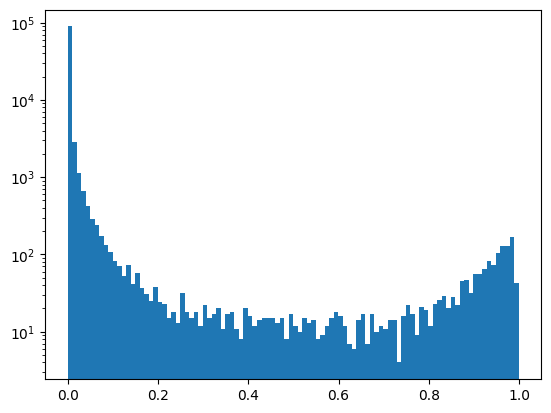

In [95]:
plt.hist(calib['score_raw'],bins=100)
plt.yscale('log')

In [96]:
# The reason we bin the records is to calculate the odds. We can then find the relationship between the raw score and the log odds.
nbins=100
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','score_raw','prob(%)','odds','log_odds', 'log_odds_adj']
cal_bins = pd.DataFrame(np.zeros((nbins+1, 14)), columns = cols)

In [97]:
bad_tot = sum(calib.loc[:, 'Fraud'])
good_tot = len(calib) - bad_tot
print(bad_tot, good_tot)

2047 95449


In [98]:
frac = 1/nbins
nrecs = calib.shape[0]
cal_bins.loc[0,'log_odds_adj'] = -8
for i in range(nbins+1):
    percent_rows_top = int(round(nrecs*frac*i))
    percent_rows_bottom = max(int(round(nrecs*frac*(i-1))),0)
    temp = calib.iloc[percent_rows_bottom:percent_rows_top,:]
    cal_bins.loc[i, 'score_raw'] = temp['score_raw'].mean()
    num_bad = int(sum(temp.loc[:,'Fraud']))
    num_tot = len(temp) * i
    num_good = int(num_tot - num_bad)
    cal_bins.loc[i, 'bin'] = i
    cal_bins.loc[i,'#recs'] = 0
    cal_bins.loc[i, 'tot'] = num_tot
    cal_bins.loc[i, 'cg'] = num_good
    cal_bins.loc[i, 'cb'] = num_bad
    if i != 0:
        cal_bins.loc[i, '#recs'] = len(temp)
        cal_bins.loc[i, '#b'] = int(sum(temp.loc[:, 'Fraud']))
        cal_bins.loc[i, '#g'] = cal_bins.loc[i, '#recs'] - cal_bins.loc[i, '#b']
        cal_bins.loc[i, '%g'] = 100* cal_bins.loc[i, '#g'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, '%b'] = 100 - cal_bins.loc[i, '%g']
        cal_bins.loc[i, 'cg'] = cal_bins.loc[i-1, 'cg'] + cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'cb'] = cal_bins.loc[i-1, 'cb'] + cal_bins.loc[i, '#b']
        cal_bins.loc[i, 'prob(%)'] = 100 * cal_bins.loc[i, '#b'] / cal_bins.loc[i, '#recs']
        cal_bins.loc[i, 'odds'] = (cal_bins.loc[i, '#b'] + .001) / cal_bins.loc[i, '#g']
        cal_bins.loc[i, 'log_odds'] = np.log2(cal_bins.loc[i, 'odds'])
        cal_bins.loc[i, 'log_odds_adj'] = max(cal_bins.loc[i, 'log_odds'], cal_bins.loc[i-1, 'log_odds_adj'])
        
cal_bins.drop(index=0,axis=0,inplace=True)
cal_bins.fillna(0)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj
1,1.0,975.0,975.0,0.0,100.000000,0.000000,975.0,975.0,0.0,0.000054,0.000000,0.000001,-19.895043,-8.000000
2,2.0,975.0,975.0,0.0,100.000000,0.000000,1950.0,1950.0,0.0,0.000073,0.000000,0.000001,-19.895043,-8.000000
3,3.0,975.0,975.0,0.0,100.000000,0.000000,2925.0,2925.0,0.0,0.000088,0.000000,0.000001,-19.895043,-8.000000
4,4.0,975.0,975.0,0.0,100.000000,0.000000,3900.0,3900.0,0.0,0.000108,0.000000,0.000001,-19.895043,-8.000000
5,5.0,975.0,975.0,0.0,100.000000,0.000000,4875.0,4875.0,0.0,0.000135,0.000000,0.000001,-19.895043,-8.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,975.0,946.0,29.0,97.025641,2.974359,93600.0,93384.0,212.0,0.033050,2.974359,0.030656,-5.027666,-5.027666
97,97.0,975.0,929.0,46.0,95.282051,4.717949,94575.0,94313.0,258.0,0.054281,4.717949,0.049517,-4.335941,-4.335941
98,98.0,975.0,801.0,174.0,82.153846,17.846154,95550.0,95114.0,432.0,0.130412,17.846154,0.217230,-2.202707,-2.202707
99,99.0,975.0,297.0,678.0,30.461538,69.538462,96525.0,95411.0,1110.0,0.586761,69.538462,2.282832,1.190824,1.190824


In [99]:
cal_bins.tail()

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj
96,96.0,975.0,946.0,29.0,97.025641,2.974359,93600.0,93384.0,212.0,0.033050,2.974359,0.030656,-5.027666,-5.027666
97,97.0,975.0,929.0,46.0,95.282051,4.717949,94575.0,94313.0,258.0,0.054281,4.717949,0.049517,-4.335941,-4.335941
98,98.0,975.0,801.0,174.0,82.153846,17.846154,95550.0,95114.0,432.0,0.130412,17.846154,0.217230,-2.202707,-2.202707
99,99.0,975.0,297.0,678.0,30.461538,69.538462,96525.0,95411.0,1110.0,0.586761,69.538462,2.282832,1.190824,1.190824
100,100.0,975.0,38.0,937.0,3.897436,96.102564,97500.0,95449.0,2047.0,0.949708,96.102564,24.657921,4.623979,4.623979


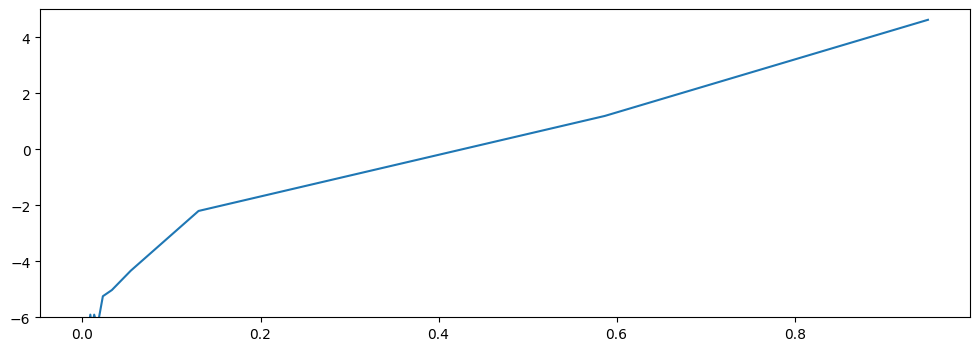

In [100]:
plt.figure(figsize=(12,4))
plt.ylim([-6,5])
plt.plot(cal_bins['score_raw'],cal_bins['log_odds'])
# plt.plot(cal_bins['score_raw'],cal_bins['log_odds_adj'])
# plt.xlim([0,1])

In [101]:
def funcg(x, a, b, c):
    return c + b/(1 + np.exp(-a * x))

def funcf(x, a, b, c):
    return -np.log(-1 + b/(x - c))/a

In [102]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(funcg, cal_bins['log_odds_adj'],cal_bins['score_raw'])   
print(popt)

[ 0.6902121   0.93890032 -0.00291449]


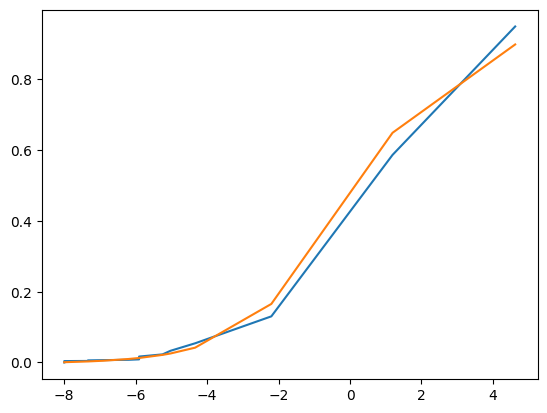

In [103]:
# plt.plot(cal_bins['log_odds'],cal_bins['score'])
plt.plot(cal_bins['log_odds_adj'],cal_bins['score_raw'])
plt.plot(cal_bins['log_odds_adj'],funcg(cal_bins['log_odds_adj'], *popt))

/opt/homebrew/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


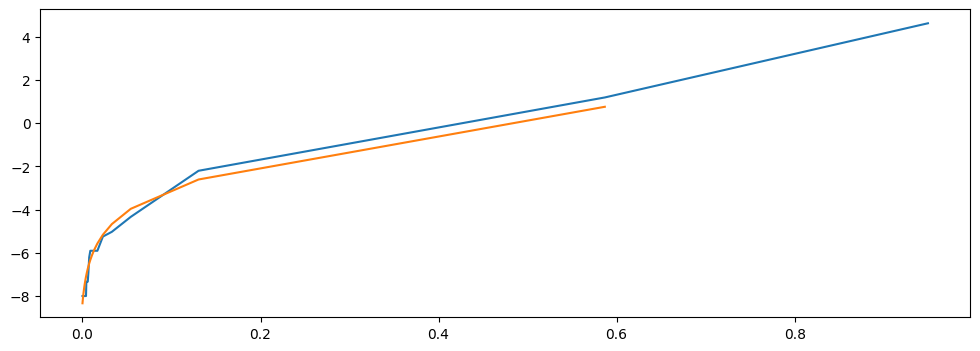

In [104]:
# look at the smooth curve fit to see if it's OK.
plt.figure(figsize=(12,4))
plt.plot(cal_bins['score_raw'], cal_bins['log_odds_adj'])
plt.plot(cal_bins['score_raw'], funcf(cal_bins['score_raw'], *popt))

In [105]:
# The fit looks pretty good
cal_bins['fit'] = funcf(cal_bins['score_raw'], *popt)
cal_bins.head(10)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj,fit
1,1.0,975.0,975.0,0.0,100.000000,0.000000,975.0,975.0,0.0,0.000054,0.000000,0.000001,-19.895043,-8.0,-8.335642
2,2.0,975.0,975.0,0.0,100.000000,0.000000,1950.0,1950.0,0.0,0.000073,0.000000,0.000001,-19.895043,-8.0,-8.326617
3,3.0,975.0,975.0,0.0,100.000000,0.000000,2925.0,2925.0,0.0,0.000088,0.000000,0.000001,-19.895043,-8.0,-8.319199
4,4.0,975.0,975.0,0.0,100.000000,0.000000,3900.0,3900.0,0.0,0.000108,0.000000,0.000001,-19.895043,-8.0,-8.309392
5,5.0,975.0,975.0,0.0,100.000000,0.000000,4875.0,4875.0,0.0,0.000135,0.000000,0.000001,-19.895043,-8.0,-8.296593
6,6.0,975.0,975.0,0.0,100.000000,0.000000,5850.0,5850.0,0.0,0.000163,0.000000,0.000001,-19.895043,-8.0,-8.283518
7,7.0,975.0,975.0,0.0,100.000000,0.000000,6825.0,6825.0,0.0,0.000186,0.000000,0.000001,-19.895043,-8.0,-8.272757
8,8.0,975.0,974.0,1.0,99.897436,0.102564,7800.0,7799.0,1.0,0.000206,0.102564,0.001028,-9.926336,-8.0,-8.263152
9,9.0,975.0,975.0,0.0,100.000000,0.000000,8775.0,8774.0,1.0,0.000224,0.000000,0.000001,-19.895043,-8.0,-8.255086
10,10.0,975.0,975.0,0.0,100.000000,0.000000,9750.0,9749.0,1.0,0.000240,0.000000,0.000001,-19.895043,-8.0,-8.247452


In [106]:
# Here's the calibrated score
cal_bins['score_calib'] = base + delta * cal_bins['fit'] - delta * np.log2(odds_at_base)
cal_bins['score_calib'].fillna(999, inplace=True)
cal_bins['score_calib'].clip(upper=999, inplace=True)

In [107]:
pd.set_option('display.max_rows', 100)
cal_bins.to_csv('cal_bins.csv')
cal_bins.tail(30)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,score_raw,prob(%),odds,log_odds,log_odds_adj,fit,score_calib
71,71.0,975.0,974.0,1.0,99.897436,0.102564,69225.0,69176.0,46.0,0.001904,0.102564,0.001028,-9.926336,-8.000000,-7.631119,513.816192
72,72.0,975.0,975.0,0.0,100.000000,0.000000,70200.0,70151.0,46.0,0.001980,0.000000,0.000001,-19.895043,-8.000000,-7.608402,514.270520
73,73.0,975.0,975.0,0.0,100.000000,0.000000,71175.0,71126.0,46.0,0.002064,0.000000,0.000001,-19.895043,-8.000000,-7.583685,514.764858
74,74.0,975.0,973.0,2.0,99.794872,0.205128,72150.0,72099.0,48.0,0.002155,0.205128,0.002057,-8.925575,-8.000000,-7.557045,515.297666
75,75.0,975.0,975.0,0.0,100.000000,0.000000,73125.0,73074.0,48.0,0.002254,0.000000,0.000001,-19.895043,-8.000000,-7.529115,515.856269
76,76.0,975.0,972.0,3.0,99.692308,0.307692,74100.0,74046.0,51.0,0.002358,0.307692,0.003087,-8.339369,-8.000000,-7.499901,516.440540
77,77.0,975.0,974.0,1.0,99.897436,0.102564,75075.0,75020.0,52.0,0.002475,0.102564,0.001028,-9.926336,-8.000000,-7.468003,517.078493
78,78.0,975.0,974.0,1.0,99.897436,0.102564,76050.0,75994.0,53.0,0.002606,0.102564,0.001028,-9.926336,-8.000000,-7.433019,517.778176
79,79.0,975.0,975.0,0.0,100.000000,0.000000,77025.0,76969.0,53.0,0.002760,0.000000,0.000001,-19.895043,-8.000000,-7.392850,518.581559
80,80.0,975.0,973.0,2.0,99.794872,0.205128,78000.0,77942.0,55.0,0.002938,0.205128,0.002057,-8.925575,-8.000000,-7.347749,519.483579


In [108]:
calib.head()

,score_raw,Fraud
48200,0.000030,0
5423,0.000031,0
46674,0.000032,0
73229,0.000033,0
61983,0.000033,0


In [109]:
calib['score_calib'] = base - delta * np.log2(odds_at_base) + delta * funcg(calib['score_raw'], *popt)
calib['score_calib'].fillna(999, inplace=True)
calib['score_calib'].clip(upper=999, inplace=True)
calib.head()

,score_raw,Fraud,score_calib
48200,0.000030,0,675.769371
5423,0.000031,0,675.769375
46674,0.000032,0,675.769380
73229,0.000033,0,675.769382
61983,0.000033,0,675.769383


In [110]:
calib.tail()

,score_raw,Fraud,score_calib
63301,0.995756,1,678.874447
63316,0.995993,1,678.875132
63333,0.995993,1,678.875132
63311,0.995993,1,678.875132
76825,0.998328,1,678.881867


In [111]:
calib.describe()

,score_raw,Fraud,score_calib
count,97496.000000,97496.000000,97496.000000
mean,0.019498,0.020996,675.831048
std,0.112863,0.143371,0.354777
min,0.000030,0.000000,675.769371
25%,0.000454,0.000000,675.770746
50%,0.000955,0.000000,675.772370
75%,0.002307,0.000000,675.776750
max,0.998328,1.000000,678.881867


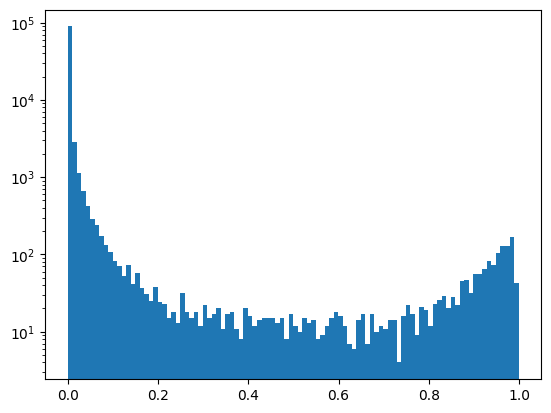

In [112]:
nbins=100
plt.hist(calib['score_raw'],bins=nbins)
plt.yscale('log')

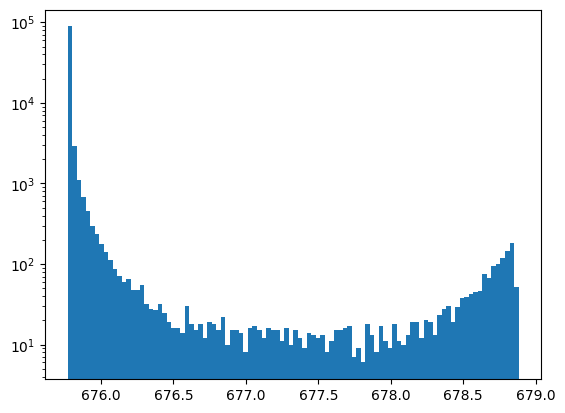

In [113]:
plt.hist(calib['score_calib'],bins=nbins)
plt.yscale('log')

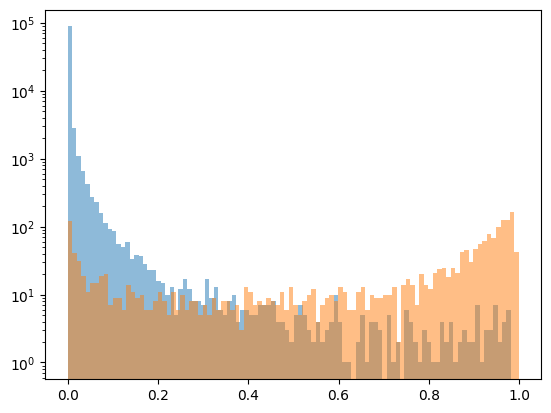

In [114]:
goods = calib[calib['Fraud']==0]
bads = calib[calib['Fraud']==1]
plt.hist(goods['score_raw'],bins = nbins, alpha = .5)
plt.hist(bads['score_raw'],bins = nbins, alpha = .5)
plt.yscale('log')

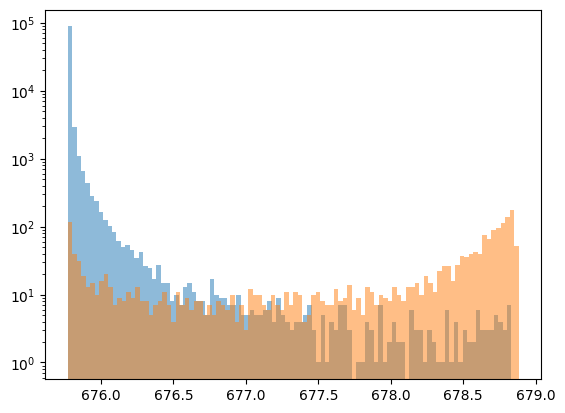

In [115]:
plt.hist(goods['score_calib'],bins = nbins, alpha = .5)
plt.hist(bads['score_calib'],bins = nbins, alpha = .5)
plt.yscale('log')

In [116]:
print("duration: ", datetime.now() - start_time)

duration:  0:04:06.177051


In [117]:
%pwd

'/Users/stevecoggeshall/Documents/Teaching/Data sets/done/transactions/give to USC 2024'